# Extract data

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_parquet("../data/train.parquet")
data.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X882,X883,X884,X885,X886,X887,X888,X889,X890,label
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,15.283,8.425,176.405,44.984,221.389,0.121263,-0.417690,0.005399,0.125948,0.058359,...,1.925423,1.847943,0.005676,0.190791,0.369691,0.377630,0.210153,0.159183,0.530636,0.562539
2023-03-01 00:01:00,38.590,2.336,525.846,321.950,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,...,1.928569,1.849468,0.005227,0.184660,0.363642,0.374515,0.209573,0.158963,0.530269,0.533686
2023-03-01 00:02:00,0.442,60.250,159.227,136.369,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,...,1.928047,1.849282,0.004796,0.178719,0.357689,0.371424,0.208993,0.158744,0.529901,0.546505
2023-03-01 00:03:00,4.865,21.016,335.742,124.963,460.705,0.072944,-0.436590,-0.102483,0.017551,0.007149,...,1.928621,1.849608,0.004398,0.172967,0.351832,0.368358,0.208416,0.158524,0.529534,0.357703
2023-03-01 00:04:00,27.158,3.451,98.411,44.407,142.818,0.173820,-0.213489,0.096067,0.215709,0.107133,...,1.927084,1.848950,0.004008,0.167391,0.346066,0.365314,0.207839,0.158304,0.529167,0.362452


In [3]:
x_data = data.iloc[:, 5:-1].copy()

In [4]:
y_data = data.iloc[:, -1].copy()

In [5]:
# Clean uninformative cols
unique_val_cols = [col for col in x_data.columns if x_data[col].nunique() == 1]
x_data.drop(columns=unique_val_cols, inplace=True)

cols_with_corr_1 = [
    'X387', 'X429', 'X381', 'X423', 'X417', 'X333', 'X369', 'X327', 'X321', 'X405', 'X399',
    'X315', 'X309', 'X393', 'X140', 'X182', 'X134', 'X176', 'X170', 'X86', 'X122', 'X80',
    'X116', 'X74', 'X68', 'X110', 'X62', 'X146'
]
x_data.drop(columns=cols_with_corr_1, inplace=True)

In [5]:
x_data_with_target = x_data.copy()
x_data_with_target["label"] = data["label"]

In [6]:
import gc

del data
# del x_data
gc.collect()

0

# Correlations of X with y

In [8]:
correlations = (
    x_data_with_target
    .drop(columns="label")
    .corrwith(x_data_with_target["label"])
    .sort_values(ascending=False)
)
print(correlations)

X21     0.069401
X20     0.067667
X28     0.064092
X863    0.064057
X29     0.062339
          ...   
X580   -0.041725
X95    -0.042948
X137   -0.044290
X524   -0.048020
X531   -0.056184
Length: 863, dtype: float64


In [9]:
top_percentile = np.percentile(x_data_with_target["label"], 95)
bot_percentile = np.percentile(x_data_with_target["label"], 5)

x_data_extreme_top = x_data_with_target[x_data_with_target["label"] > top_percentile]
x_data_extreme_bot = x_data_with_target[x_data_with_target["label"] < bot_percentile]
x_data_extreme = pd.concat([x_data_extreme_top, x_data_extreme_bot])

In [10]:
del x_data_with_target
gc.collect()

0

In [11]:
for df in [x_data_extreme_top, x_data_extreme_bot, x_data_extreme]:
    correlations = (
        df
        .drop(columns="label")
        .corrwith(df["label"])
        .sort_values(ascending=False)
    )
    print(correlations)

X849    0.181019
X205    0.178474
X729    0.176885
X181    0.176761
X175    0.176409
          ...   
X173   -0.185095
X426   -0.186230
X179   -0.187539
X420   -0.199055
X414   -0.204036
Length: 863, dtype: float64
X841    0.185548
X837    0.183585
X833    0.181078
X221    0.180494
X777    0.177421
          ...   
X594   -0.185491
X9     -0.190387
X879   -0.192173
X878   -0.216843
X877   -0.236934
Length: 863, dtype: float64
X181    0.184705
X471    0.184108
X856    0.182991
X175    0.182231
X472    0.181195
          ...   
X9     -0.170084
X137   -0.173009
X131   -0.174823
X524   -0.186248
X531   -0.206567
Length: 863, dtype: float64


# PCA

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [8]:
scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)

pca = PCA()
x_data = pca.fit_transform(x_data)

pca_eigval = pca.explained_variance_

# Kaiser's criterion
n_components = (pca.explained_variance_ > 1).sum()
print(n_components)
print(x_data)

113
[[-8.74548326e+00  5.33448666e+00  1.23959013e-01 ... -2.07260259e-11
  -3.96066682e-10 -4.79068294e-10]
 [-8.05766245e+00  5.40718040e+00 -9.01364442e-02 ...  9.21393773e-12
  -2.06310305e-09  3.62645878e-10]
 [-8.28078387e+00  4.98586867e+00 -1.73311187e-01 ...  2.13921263e-11
  -2.01046679e-09  5.22234190e-10]
 ...
 [-1.80864124e+00 -1.73339974e+00 -4.60765365e+00 ...  6.30344442e-11
  -1.50106663e-09  8.83248499e-10]
 [-3.11439931e+00 -2.78814793e+00 -4.24705417e+00 ...  8.20620507e-11
  -3.33879759e-09 -8.61553786e-10]
 [-8.12459482e+00 -7.47615005e+00 -1.48260459e+00 ... -8.20150878e-11
  -1.23518739e-09 -3.75789296e-09]]


In [ ]:
print(pca.explained_variance_ratio_[:n_components].sum())

0.9001244687052725


# Cross-correlations

In [8]:
corr_matrix = x_data.corr(method="pearson")

In [8]:
del x_data

In [9]:
print(corr_matrix.head())

          X1        X2        X3        X4        X5        X6        X7  \
X1  1.000000  0.598175  0.728431  0.802451  0.866625  0.940304  0.967332   
X2  0.598175  1.000000  0.922680  0.833476  0.750923  0.662548  0.632626   
X3  0.728431  0.922680  1.000000  0.972715  0.911029  0.814884  0.776297   
X4  0.802451  0.833476  0.972715  1.000000  0.977425  0.899116  0.858607   
X5  0.866625  0.750923  0.911029  0.977425  1.000000  0.962555  0.927415   

          X8        X9       X10  ...      X881      X882      X883      X884  \
X1  0.982965  0.731654  0.552883  ... -0.017123 -0.015580 -0.014643 -0.007572   
X2  0.615937  0.262676  0.777890  ... -0.000061  0.000159  0.000240  0.001636   
X3  0.753582  0.362567  0.787828  ...  0.001298  0.001278  0.001112  0.002442   
X4  0.832757  0.436232  0.742130  ...  0.001596  0.001771  0.001594  0.002940   
X5  0.901096  0.513176  0.685651  ...  0.000102  0.001165  0.001413  0.002205   

        X885      X886      X887      X888      X889    

In [10]:
corr_pairs = corr_matrix.stack().sort_values()
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0).str[1:].astype(int) != corr_pairs.index.get_level_values(1).str[1:].astype(int)]
print(corr_pairs)

X853  X854   -0.930292
X854  X853   -0.930292
X594  X596   -0.916128
X596  X594   -0.916128
X861  X532   -0.905538
                ...   
X74   X116    1.000000
X68   X152    1.000000
      X110    1.000000
X62   X146    1.000000
      X104    1.000000
Length: 743906, dtype: float64


In [11]:
from collections import defaultdict

perfect_corrs = corr_pairs[corr_pairs == 1]

graph = defaultdict(set)

for index_1, index_2 in perfect_corrs.index:
    graph[index_1].add(index_2)
    graph[index_2].add(index_1)

In [14]:
def dfs(node, visited, group):
    visited.add(node)
    group.add(node)
    for neighbor in graph[node]:
        if neighbor not in visited:
            dfs(neighbor, visited, group)

visited = set()
groups = []

for node in graph:
    if node not in visited:
        group = set()
        dfs(node, visited, group)
        groups.append(group)

In [16]:
for i in range(len(groups)):
    groups[i] = tuple(groups[i])
    groups[i] = groups[i][1:]
    
print(groups)

[('X387', 'X429'), ('X381', 'X423'), ('X417', 'X333'), ('X369', 'X327'), ('X321', 'X405'), ('X399', 'X315'), ('X309', 'X393'), ('X140', 'X182'), ('X134', 'X176'), ('X170', 'X86'), ('X122', 'X80'), ('X116', 'X74'), ('X68', 'X110'), ('X62', 'X146')]


In [18]:
flattened = list([item for tup in groups for item in tup])
print(flattened)

['X387', 'X429', 'X381', 'X423', 'X417', 'X333', 'X369', 'X327', 'X321', 'X405', 'X399', 'X315', 'X309', 'X393', 'X140', 'X182', 'X134', 'X176', 'X170', 'X86', 'X122', 'X80', 'X116', 'X74', 'X68', 'X110', 'X62', 'X146']


# SHAP with XGBoost

In [7]:
import xgboost
import shap

c:\Users\armin\Documents\GitHub\kaggle-crypto-market-prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
model_xgb = xgboost.XGBRegressor(n_estimators=1000, max_depth=5).fit(x_data, y_data)

x_data_sample = shap.utils.sample(x_data, 1000)

explainer_xgb = shap.Explainer(model_xgb, x_data_sample)
shap_values_xgb = explainer_xgb(x_data)

100%|===================| 525845/525887 [265:29<00:01]         

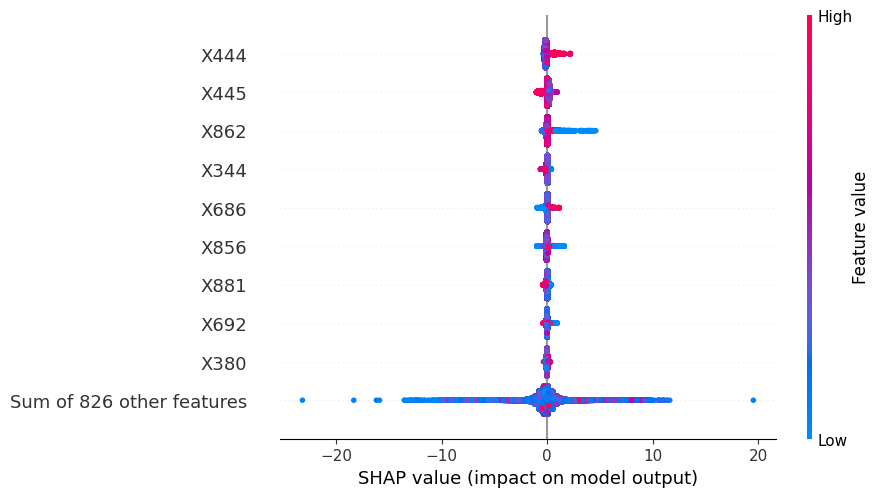

In [11]:
shap.plots.beeswarm(shap_values_xgb)

In [ ]:
import h5py

with h5py.File('shap_values_xgb.h5', 'w') as f:
    f.create_dataset('shap_values', data=shap_values_xgb)

In [ ]:
with h5py.File('shap_values_xgb.h5', 'r') as f:
    loaded_arr = f['shap_values'][:]